In [1]:
# sarcasm json data binary classification
# total 26,709 headlines  

In [1]:
import json
import tensorflow as tf
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.17.0


In [9]:
# data = "Hello LSTM network!! I am a student. Goodbye  안녕하세요"
# word_list = data.split()
# print(word_list)
# print(word_list[0],word_list[-1])

In [3]:
# sarcasm.json 데이터셋 파일 다운로드 , Windows용
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x19b2ca2d3c0>)

In [4]:
# 데이터 파일 불러오기
with open('sarcasm.json','r') as f:
    datastore = json.load(f)
print(datastore[0])   
print(type(datastore[0]))

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}
<class 'dict'>


In [5]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])  # 리스트에 texdt를 추가
    labels.append(item['is_sarcastic'])

print(sentences[:10])
print(labels[:10])

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way', "advancing the world's women", 'the fascinating case for eating lab-grown meat', 'this ceo will send your kids to school, if you work for his company', 'top snake handler leaves sinking huckabee campaign', "friday's morning email: inside trump's presser for the ages"]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]


In [6]:
# d = {'name':'홍길동'}
# print(d['name'])
# d = datastore[0]
# print(d['headline'])
# print(d['is_sarcastic'])

In [7]:
# pandas 의 데이터 프레임
import pandas as pd
df = pd.DataFrame(datastore)
df = df.iloc[:,1:]
print(df.shape)  # (26709,2)
df['is_sarcastic'].value_counts()  # label의 분포를 확인
                                   # 0    14985 : not sarcastic 
                                   # 1    11724 : sarcastic
df

(26709, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [52]:
# 정형 포맷 데이터 : csv,엑셀
# 비정형 데이터 : 문자,음성,이미지
# 반정형 데이터 : JSON

### 텍스트 전처리: Tokenizer 사용

In [17]:
# 전처리를 위한 변수 설정
vocab_size = 10000        # 토큰화에 사용될 최대 어휘수 ,  Weight의 갯수(행)
embedding_dim = 16        # Embedding 계층의 output size , Weight의 갯수(열,D)   
max_length = 100          # 한 문장의 길이, 데이터 셋의 길이, maxlen, sequence_length(T)
trunc_type = 'post'       # maxlen보다 클때 잘라낼 유형, 'post' : 뒤쪽
padding_type = 'post'     # maxlen보다 작을때 0을 추가할 유형, 'post' : 뒤쪽
oov_tok = "<OOV>"         # Out-Of-Vocabulary(단어 집합에 없는 단어)
training_size = 20000     # 학습 데이터의 갯수
# "<sos>" : start of senetence token
# "<eos>" : end of sentence token

In [19]:
# train(20000)/test(6709) data split 
training_senteces = sentences[:training_size]
training_labels = labels[:training_size]

testing_senteces = sentences[training_size:]
testing_labels = labels[training_size:]

print(len(training_senteces),len(training_labels))
print(len(testing_senteces),len(testing_labels))

20000 20000
6709 6709


In [52]:

# 가장 빈도가 높은 10000개의 단어들만 사용하여 토큰화
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)

# 단어 인덱스(집합)를 구축
tokenizer.fit_on_texts(training_senteces)
# print(tokenizer.word_index) # 인덱스 사전
# print(tokenizer.word_counts) # 단어의 빈도

# 정수 인코딩 : 문자열 단어--> 정수
# 문자열을 정수 인덱스의 리스트로 변환 
training_sequences = tokenizer.texts_to_sequences(training_senteces)
# print(training_sequences[:10])

# 패딩, 배열 벡터 표현을 얻음 : 신경망에 입력할 X값
training_padded =  pad_sequences(training_sequences,maxlen=max_length,
                                padding=padding_type,truncating=trunc_type)
# print(training_padded[:10])


# test 데이터 : 정수 인덱스의 리스트로 변환 (인코딩)
testing_sequences = tokenizer.texts_to_sequences(testing_senteces)

# test 데이터 : 벡터 표현을 얻음 , 패딩
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type,truncating=trunc_type)

training_padded.shape  # train  X: (20000, 100)
testing_padded.shape   # test X : (6709, 100)

(6709, 100)

In [57]:
# Y값의 타입을 리스트에서 배열로 변환
import numpy as np
training_labels = np.array(training_labels)  
testing_labels = np.array(testing_labels)
print(training_labels.shape,testing_labels.shape)

(20000,) (6709,)


### 학습모델

In [76]:
model = tf.keras.Sequential([
    # W: (10000*16)  , 출력 : (N,T,D) (N,100,16)
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_shape=(max_length,)),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),  # feature를 1 차원 벡터로 변환
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 100, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,577 (627.25 KB)

 Trainable params: 160,577 (627.25 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# 학습
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5611 - loss: 0.6838 - val_accuracy: 0.6605 - val_loss: 0.6502
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6965 - loss: 0.5913 - val_accuracy: 0.7869 - val_loss: 0.4581
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8140 - loss: 0.4146 - val_accuracy: 0.8237 - val_loss: 0.4005
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8537 - loss: 0.3448 - val_accuracy: 0.7621 - val_loss: 0.4890
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8683 - loss: 0.3154 - val_accuracy: 0.8496 - val_loss: 0.3577
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8881 - loss: 0.2762 - val_accuracy: 0.8229 - val_loss: 0.3874
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8905 - loss: 0.2612 - val_accuracy: 0.8532 - val_loss: 0.3505
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9028 - loss: 0.2385 - val_accuracy: 0.

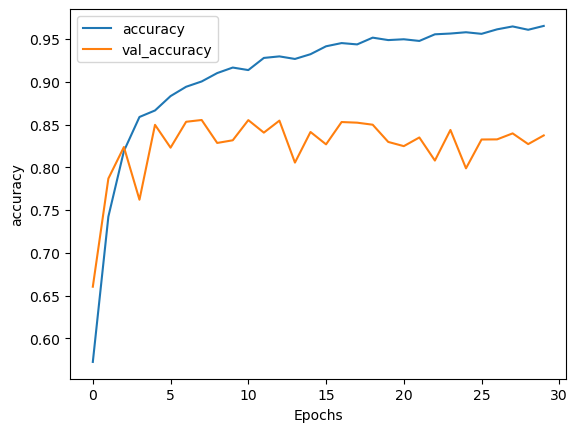

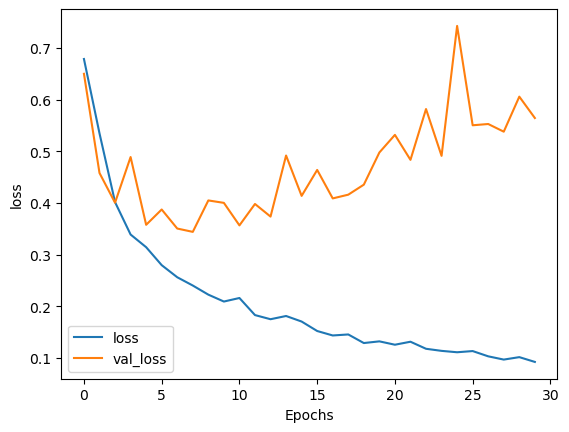

In [78]:
# 시각화
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 모델 개선

In [87]:
# LSTM 사용
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_shape=(max_length,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=64,return_sequences=True),  # (N,T,H):(N,100,64)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=32),                        # (N,H):(N,32)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ (None, 100, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100, 64)             │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,329 (763.00 KB)

 Trainable params: 195,329 (763.00 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# 학습
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))

In [91]:
# LSTM 사용
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_shape=(max_length,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,return_sequences=True)),  # (N,T,H):(N,100,64)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),                        # (N,H):(N,32)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)             │ (None, 100, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,913 (964.50 KB)

 Trainable params: 246,913 (964.50 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# 학습
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))
# 성능 약간 개선됨

In [97]:
# decoding : 숫자 -> 문장(단어들)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_senteces[2])
print(labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
# 예측
sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,
                       truncating=trunc_type)
padded.shape  # (2,100)
preds = model.predict(padded)
print(preds)
print(np.round(preds))

In [ ]:
# 예측
sentence = ["Head of Canada's spy agency announces he's stepping down from the job",
            "Old Video of Joe Biden Talking About Resignation Falsely Shared as Recent"]
           
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,
                       truncating=trunc_type)
print(padded.shape)  # (2,100)
preds = model.predict(padded)
print(preds)
print(np.round(preds))